Processing: no spread
-----------------------------------------
3 species: Su, N, N_200.0kg
Number of shells: 24
Number of active species: 1
Number of active species per shell: 24
-----------------------------------------
Propagation time: 0.0162 seconds
Processing: spread
-----------------------------------------
3 species: Su, N, N_200.0kg
Number of shells: 24
Number of active species: 1
Number of active species per shell: 24
-----------------------------------------
Propagation time: 0.0769 seconds


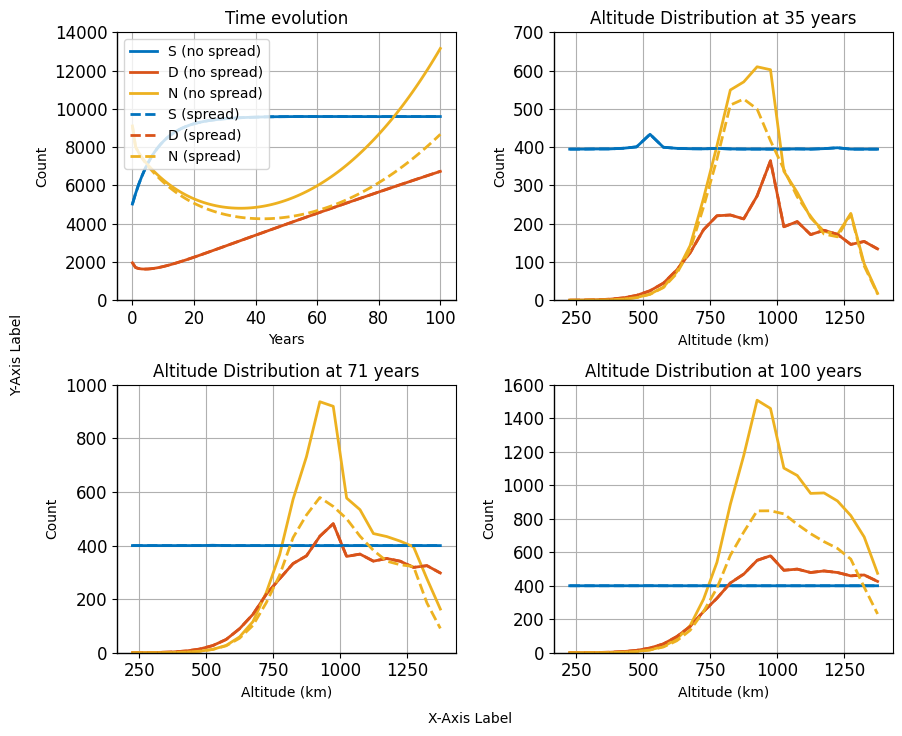

In [82]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
import time
from utils.control.control import *


scenario_files = ['../scenario-properties-test-opt-nospread.pkl', '../scenario-properties-test-opt-yesspread.pkl']
# scenario_files = ['../scenario-properties-test-opt-nospread.pkl', '../scenario-properties-test-opt-yesspread_new.pkl']
scenario_names = ['no spread', 'spread']
linestyles = ['-', '--']

# Loop through the two cases, no control and simple control
all_results = {} # Dictionary to hold the results from each scenario for plotting
for i, scenario_file in enumerate(scenario_files):

    print(f"Processing: {scenario_names[i]}")

    with open(scenario_file, 'rb') as f:
        baseline = pickle.load(f)
        
    # Find the difference (symbols in equations but not in all_symbolic_vars) after 
    # converting the list to a set for efficient difference calculation
    difference_vars = baseline.equations.free_symbols - set(baseline.all_symbolic_vars)
    ordered_difference_vars = sorted(list(difference_vars), key=lambda x: sort_key(str(x), baseline.species_names))

    vars_dict = create_vars_dict(ordered_difference_vars)
    # print("-----------------------------------------")
    # for name, var_list in vars_dict.items():
    #     print(f"{name}: {var_list}")

    equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

    # Parameters
    N_shell = baseline.n_shells
    R02 = baseline.R0_km

    # #==========================================================================
    # # Define symbolic variables based on loaded scenario
    # #==========================================================================
    Pm_s, deltat_s, lam_s, u_var_s = extract_vars(vars_dict)
    var_s = baseline.all_symbolic_vars

    active_species_indices = int(len(lam_s)/N_shell)
    active_species_per_shells = len(lam_s)

    print("-----------------------------------------")
    print(f"{baseline.species_length} species: {', '.join(baseline.species_names)}")
    print(f"Number of shells: {baseline.n_shells}")
    print(f"Number of active species: {active_species_indices}")
    print(f"Number of active species per shell: {active_species_per_shells}")
    print("-----------------------------------------")

    #==========================================================================
    # Define propagation function
    #==========================================================================

    # func = sp.lambdify((var_s, lam_s), equations_flattened, 'numpy')
    # def ode_func(t, x, func, mdd):
    #      return np.array(func(x, mdd)).flatten()
    
    f3 = equations_flattened
    fun3 = sp.lambdify((var_s, lam_s), f3, 'numpy')
    def func(t, x, fun3, x0_lam):
        """ODE system function for solve_ivp."""
        return np.array(fun3(x, np.array(x0_lam))).flatten()

    #==========================================================================
    # Initial condition
    #==========================================================================
    x0 = [0,
            7,
            38,
            44,
            173,
            456,
            2977,
            379,
            157,
            79,
            59,
            144,
            43,
            17,
            15,
            10,
            1,
            43,
            3,
            101,
            277,
            0,
            2,
            0,
            23,
            15,
            32,
            91,
            186,
            227,
            194,
            309,
            340,
            519,
            830,
            1223,
            1381,
            1160,
            696,
            487,
            353,
            256,
            207,
            145,
            104,
            244,
            86,
            0,
            8,
            3,
            10,
            31,
            114,
            91,
            117,
            98,
            129,
            120,
            150,
            215,
            144,
            80,
            116,
            288,
            56,
            73,
            35,
            39,
            11,
            9,
            18,
            0]
    x0 = np.array(x0)
    x0 = x0.astype(int)
    # # Create pandas DataFrame (equivalent to MATLAB's table)
    # df = pd.DataFrame(x0.reshape((baseline.species_length,N_shell)).T, columns=baseline.species_names)
    # # print(df.to_string(index=False)) # Print DataFrame without index

    # # Print table with shell numbers (optional)
    # df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((baseline.species_length,N_shell)).T)), 
    #                                 columns=['Shell'] + baseline.species_names)
    # print(df_with_shell.to_string(index=False)) # Print DataFrame without index

    #==========================================================================
    # Propagation without control
    #==========================================================================

    # Propagation time
    tf_ss = 100.0
    dur = tf_ss
    Ts = 1.0
    tspan = np.arange(0, dur+Ts, Ts)

    # ODE tolerances
    rtol = 1e-2
    atol = 1e-2

    x00 = x0
    # x0_lam = np.ones((N_shell,len(tspan))) * 50.0
    x0_lam = np.ones(N_shell) * 50.0 * 1
    x_prop = np.zeros((len(tspan), baseline.species_length*N_shell))
    x_prop[0, :] = x00

    start_time = time.time()

    # for i1 in range(len(tspan) - 1):
    #     md = x0_lam[:,i1]
    #     sol = solve_ivp(ode_func, 
    #                     (tspan[i1], tspan[i1+1]), 
    #                     x00, 
    #                     method=baseline.integrator,
    #                     args=(func,md),
    #                     rtol=rtol, atol=atol)
    #     x_prop[i1+1, :] = sol.y[:, -1]
    #     x00 = sol.y[:, -1]

    tspan = np.linspace(0, tf_ss, 100)
    sol = solve_ivp(func, (0, tf_ss), x00, 
                    method=baseline.integrator,
                    t_eval=tspan, 
                    args=(fun3,x0_lam),
                    rtol=1e-2, atol=1e-2)
    t_prop = sol.t
    x_prop = sol.y.T
        
    propagation_time = time.time() - start_time
    print(f"Propagation time: {propagation_time:.4f} seconds")    
    t_prop = tspan

    # Store results for this scenario
    all_results[scenario_names[i]] = {'t_prop': t_prop, 'x_prop': x_prop, 'R02': R02, 'N_shell': N_shell} # Save to the dictionary

#-------------------Setting up visualization-----------------------------#
colors = [
    [0, 0, 0],
    [0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
]
sel_LineWidth = 2
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 12

# Create Subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), facecolor='w') # 2 rows, 2 columns

# Common X Label
fig.text(0.5, 0.04, 'X-Axis Label', ha='center')
fig.text(0.04, 0.5, 'Y-Axis Label', va='center', rotation='vertical')

# Plots (Iterate over scenarios)

for scenario_name, scenario_data in all_results.items():  #Iterate on the dict

        t_prop = scenario_data['t_prop'] # Get the dict values to be ploted with variables
        x_prop = scenario_data['x_prop']
        R02 = scenario_data['R02']
        N_shell = scenario_data['N_shell']

        linestyle = linestyles[list(all_results.keys()).index(scenario_name)] # Get different linesyles for different names


        # Plot 1: Time Evolution
        S_prop = x_prop[:,0:N_shell]
        N_prop = x_prop[:,N_shell:2*N_shell]
        D_prop = x_prop[:,2*N_shell:3*N_shell]
        N_tot = S_prop + D_prop + N_prop
        N_tot_sum = np.sum(N_tot,1)
        S_sum = np.sum(S_prop,1)
        D_sum = np.sum(D_prop,1)
        N_sum = np.sum(N_prop,1)
        axes[0, 0].grid(True)
        axes[0, 0].plot(t_prop, S_sum, color=colors[1], linewidth=sel_LineWidth, linestyle=linestyle, label=f'S ({scenario_name})')
        axes[0, 0].plot(t_prop, D_sum, color=colors[2], linewidth=sel_LineWidth, linestyle=linestyle, label=f'D ({scenario_name})')
        axes[0, 0].plot(t_prop, N_sum, color=colors[3], linewidth=sel_LineWidth, linestyle=linestyle, label=f'N ({scenario_name})')
        axes[0, 0].set_title("Time evolution")
        axes[0, 0].set_xlabel("Years")
        axes[0, 0].set_ylabel("Count")
        axes[0, 0].legend(loc="best") # All labels added to one line
        axes[0, 0].tick_params(axis='both', which='major', labelsize=sel_FontSize)
        axes[0, 0].spines['bottom'].set_linewidth(sel_LineWidthAxis)
        axes[0, 0].spines['left'].set_linewidth(sel_LineWidthAxis)
        # axes[0, 0].set_ylim(0,10000)
        axes[0, 0].set_ylim(0,14000)

        # Plot 2: Altitude Distribution at t = 35
        S_prop_35 = x_prop[35,0:N_shell]
        N_prop_35 = x_prop[35,N_shell:2*N_shell]
        D_prop_35 = x_prop[35,2*N_shell:3*N_shell]

        axes[0, 1].grid(True)
        axes[0, 1].plot(R02[1:] - 25, S_prop_35, linestyle=linestyle, color=colors[1], linewidth=sel_LineWidth, label=f'S ({scenario_name})')
        axes[0, 1].plot(R02[1:] - 25, D_prop_35, linestyle=linestyle, color=colors[2], linewidth=sel_LineWidth, label=f'D ({scenario_name})')
        axes[0, 1].plot(R02[1:] - 25, N_prop_35, linestyle=linestyle, color=colors[3], linewidth=sel_LineWidth, label=f'N ({scenario_name})')
        axes[0, 1].set_title(f"Altitude Distribution at {t_prop[35]:.0f} years")
        axes[0, 1].set_xlabel("Altitude (km)")
        axes[0, 1].set_ylabel("Count")
        axes[0, 1].tick_params(axis='both', which='major', labelsize=sel_FontSize)
        axes[0, 1].spines['bottom'].set_linewidth(sel_LineWidthAxis)
        axes[0, 1].spines['left'].set_linewidth(sel_LineWidthAxis)
        # axes[0, 1].set_ylim(0,600)
        axes[0, 1].set_ylim(0,700)

        # Plot 3: Altitude Distribution at t = 70
        S_prop_70 = x_prop[70,0:N_shell]
        N_prop_70 = x_prop[70,N_shell:2*N_shell]
        D_prop_70 = x_prop[70,2*N_shell:3*N_shell]
        axes[1, 0].grid(True)
        axes[1, 0].plot(R02[1:] - 25, S_prop_70, linestyle=linestyle, color=colors[1], linewidth=sel_LineWidth, label=f'S ({scenario_name})')
        axes[1, 0].plot(R02[1:] - 25, D_prop_70, linestyle=linestyle, color=colors[2], linewidth=sel_LineWidth, label=f'D ({scenario_name})')
        axes[1, 0].plot(R02[1:] - 25, N_prop_70, linestyle=linestyle, color=colors[3], linewidth=sel_LineWidth, label=f'N ({scenario_name})')
        axes[1, 0].set_title(f"Altitude Distribution at {t_prop[70]:.0f} years")
        axes[1, 0].set_xlabel("Altitude (km)")
        axes[1, 0].set_ylabel("Count")
        axes[1, 0].tick_params(axis='both', which='major', labelsize=sel_FontSize)
        axes[1, 0].spines['bottom'].set_linewidth(sel_LineWidthAxis)
        axes[1, 0].spines['left'].set_linewidth(sel_LineWidthAxis)
        # axes[1, 0].set_ylim(0,500)
        axes[1, 0].set_ylim(0,1000)

        # Plot 4: Altitude Distribution at t = end
        S_prop_end = x_prop[-1,0:N_shell]
        N_prop_end = x_prop[-1,N_shell:2*N_shell]
        D_prop_end = x_prop[-1,2*N_shell:3*N_shell]
        axes[1, 1].grid(True)
        axes[1, 1].plot(R02[1:] - 25, S_prop_end, linestyle=linestyle, color=colors[1], linewidth=sel_LineWidth, label=f'S ({scenario_name})')
        axes[1, 1].plot(R02[1:] - 25, D_prop_end, linestyle=linestyle, color=colors[2], linewidth=sel_LineWidth, label=f'D ({scenario_name})')
        axes[1, 1].plot(R02[1:] - 25, N_prop_end, linestyle=linestyle, color=colors[3], linewidth=sel_LineWidth, label=f'N ({scenario_name})')
        axes[1, 1].set_title(f"Altitude Distribution at {t_prop[-1]:.0f} years")
        axes[1, 1].set_xlabel("Altitude (km)")
        axes[1, 1].set_ylabel("Count")
        axes[1, 1].tick_params(axis='both', which='major', labelsize=sel_FontSize)
        axes[1, 1].spines['bottom'].set_linewidth(sel_LineWidthAxis)
        axes[1, 1].spines['left'].set_linewidth(sel_LineWidthAxis)
        # axes[1, 1].set_ylim(0,400)
        axes[1, 1].set_ylim(0,1600)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust layout and make space to labels and title
plt.show()


In [83]:
len(np.arange(200, 2050, 50))

37

In [84]:
# np.random.seed(1234) 

mu = 5
sigma = 2
# N = mu + sigma * np.random.randn(*np.shape(mu))
N = mu + sigma * randn2(*np.shape(mu))
print(N)
N = np.random.rand(*np.shape(mu))
print(N)

4.118342259654721
0.5029668331126184
